In [5]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Dense, LayerNormalization
from tensorflow.keras.layers import MultiHeadAttention, Dropout, LayerNormalization
from tensorflow.keras.models import Model

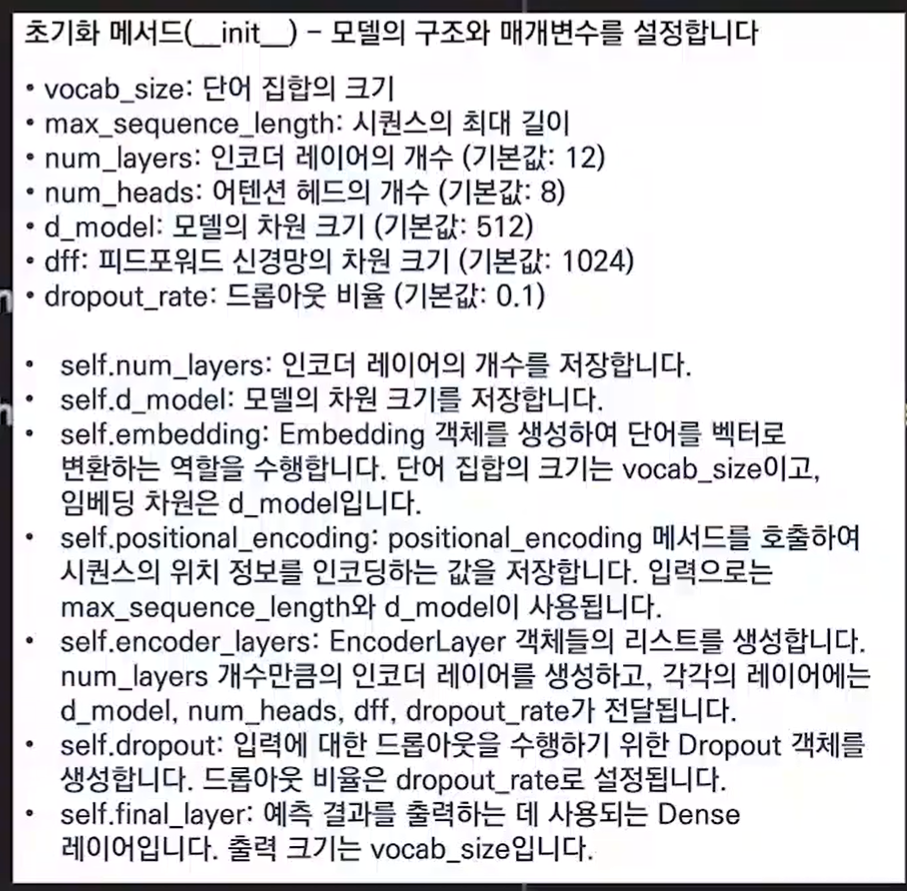

In [6]:
class GPT2(tf.keras.Model):
    def __init__(self, vocab_size, max_sequence_length, num_layers=12, num_heads=8, d_model=512, dff=1024, dropout_rate=0.1):
        super(GPT2, self).__init__()
        self.num_layers = num_layers
        self.d_model = d_model

        self.embedding = Embedding(vocab_size, d_model)
        self.positional_encoding = self.positional_encoding(max_sequence_length, d_model)

        self.encoder_layers = [EncoderLayer(d_model, num_heads, dff, dropout_rate) for _ in range(num_layers)]
        self.dropout = Dropout(dropout_rate)

        self.final_layer = Dense(vocab_size)

    def call(self, inputs):
        sequence_length = tf.shape(inputs)[1]
        mask = self.create_padding_mask(inputs)

        # Embedding and positional encoding
        x = self.embedding(inputs)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.positional_encoding[:, :sequence_length, :]
        x = self.dropout(x)

        # Encoder layers
        for i in range(self.num_layers):
            x = self.encoder_layers[i](x, mask)

        output = self.final_layer(x)
        return output

    def positional_encoding(self, sequence_length, d_model):
        position = tf.expand_dims(tf.range(0, sequence_length, dtype=tf.float32), axis=1)
        div_term = tf.pow(10000, 2 * tf.range(0, d_model, 2, dtype=tf.float32) / d_model)
        pe = tf.concat([tf.sin(position / div_term), tf.cos(position / div_term)], axis=1)
        return tf.expand_dims(pe, axis=0)

    def create_padding_mask(self, sequence):
        mask = tf.cast(tf.math.equal(sequence, 0), tf.float32)
        return mask[:, tf.newaxis, tf.newaxis, :]

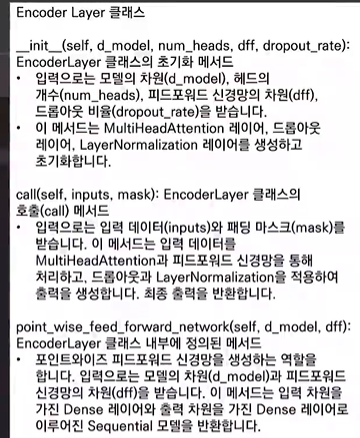

In [7]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, dropout_rate):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.dropout1 = Dropout(dropout_rate)
        self.ln1 = LayerNormalization(epsilon=1e-6)

        self.ffn = self.point_wise_feed_forward_network(d_model, dff)
        self.dropout2 = Dropout(dropout_rate)
        self.ln2 = LayerNormalization(epsilon=1e-6)

    def call(self, inputs, mask):
        attention_output = self.mha(inputs, inputs, attention_mask=mask)
        attention_output = self.dropout1(attention_output)
        output1 = self.ln1(inputs + attention_output)

        ffn_output = self.ffn(output1)
        ffn_output = self.dropout2(ffn_output)
        output2 = self.ln2(output1 + ffn_output)

        return output2

    def point_wise_feed_forward_network(self, d_model, dff):
        return tf.keras.Sequential([
            Dense(dff, activation='relu'),
            Dense(d_model)
        ])

In [13]:
# Example usage (continued):

# Define hyperparameters
num_layers = 12
num_heads = 8
d_model = 512
dff = 1024
dropout_rate = 0.1
# vocab_size=1000
# max_sequence_length=1000
# Create an instance of the GPT-2 model
gpt2 = GPT2(vocab_size, max_sequence_length, num_layers, num_heads, d_model, dff, dropout_rate)

# Compile the model
gpt2.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))

# Train the model
gpt2.fit(train_dataset, epochs=10)

# Generate text using the trained model
input_sequence = "Once upon a time"
generated_text = generate_text(gpt2, input_sequence, max_length=100)

print(generated_text)

NameError: ignored

**GPT2 with HuggingFace transformers**

In [9]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 51.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 100.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 73.8 MB/s eta 0:00:00


In [15]:
from transformers import TFGPT2LMHeadModel, GPT2Tokenizer

# Load pre-trained GPT-2 model and tokenizer
model_name = 'gpt2'
model = TFGPT2LMHeadModel.from_pretrained(model_name)
tokenizer = GPT2Tokenizer.from_pretrained(model_name)



All PyTorch model weights were used when initializing TFGPT2LMHeadModel.

All the weights of TFGPT2LMHeadModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In [ ]:

# Generate text using the GPT-2 model
def generate_text(input_text, max_length=100):
    input_ids = tokenizer.encode(input_text, return_tensors='tf')
    output = model.generate(input_ids, max_length=max_length, num_return_sequences=1,temperature=1)
    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)
    return generated_text

# Example usage:
input_sequence = "Once upon a time"
generated_text = generate_text(input_sequence, max_length=100)

In [14]:
print(generated_text)

Once upon a time, the world was a place of great beauty and great danger. The world was a place of great danger, and the world was a place of great danger. The world was a place of great danger, and the world was a place of great danger. The world was a place of great danger, and the world was a place of great danger. The world was a place of great danger, and the world was a place of great danger. The world was a place of great
